In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

In [8]:
path = Path('/app/data/raw/fossil_infrastructure.xlsx')
assert path.exists()

In [9]:
# eip = dbcp.extract.eip_infrastructure.extract(path)
# hardcode the extract function so this notebook can be easily rerun in the future without maintenance
proj = pd.read_excel(path, sheet_name='Project')

In [10]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [11]:
proj.shape

(768, 39)

# Cleaning
## Projects Cleaning
- [x] Accuracy
- [x] Atomicity
- [ ] Consistency
- [x] Completeness
- [x] Uniformity
- [x] Validity
    - [x] Range Validation
    - [x] Uniqueness Validation
    - [x] Set Membership Validation
    - [x] Type Validation
    - [x] Cross-Field Validation

### Accuracy
The biggest accuracy risks for this dataset are probably 1) bad reporting to the EPA (would take a huge research effort to double check that) and 2) transcription errors by EIP between the PDFs and the database. I'll do a little spot check to guard againt the second.

Results: I only checked 3 facilities but still managed to find conflicting information about CO2e numbers 😕

In [12]:
proj.sample(3, random_state=42)

,id,name,created_on,modified_on,Facility (ID),Facility,CCS (ID),CCS,Project Description,Classification,Industry Sector,Project Type,Air Construction (ID),Air Construction,Air Operating (ID),Air Operating,NGA (ID),NGA,MARAD (ID),MARAD,Other Permits (ID),Other Permits,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs),Total Wetlands Affected Temporarily (acres),Total Wetlands Affected Permanently (acres),Detailed Permitting History,Emission Accounting Notes,Construction Status Last Updated,Operating Status,Actual or Expected Completion Year,Project Cost (million $),Number of Jobs Promised,Target List
668,4981,Crossroads Plant - Plants I and II Initial Con...,2022-04-18T13:37:17.978814,2022-04-18T14:40:14.151570,4982,Crossroads Plant[4982],NaN,NaN,Construction of two new natural gas compressio...,New,Natural Gas,"Gas Processing Plant, Compressor Station",4984,0760-01919-00[4984],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1258712.0,9.740,24.72,26.760,1.750,44.570,17.100,NaN,NaN,NaN,Taken from page 15 of the permit application. ...,2022-04-18,Pre-construction,2023,NaN,NaN,NaN
324,3057,Epic Robstown Fractionator - Initial Construction,2021-05-24T22:56:59.087382,2022-04-05T17:05:41.350262,1042,Epic Y-Grade Logistics - Robstown Fractionator...,NaN,NaN,"Construction of a new fractionation plant, whi...",New,Petrochemicals and Plastics,Natural Gas Liquids Fractionator,1908,105349[1908],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.480,36.98,97.780,0.490,90.400,NaN,NaN,NaN,"105349 (issued 2/26/2016, revised 10/2/2018)",Emissions taken from final standard Permit Reg...,NaN,Operating,2020/2021,NaN,NaN,NaN
624,4645,Olive Creek 1,2021-12-20T17:59:27.593436,2021-12-21T22:43:00.848256,4643,Monolith Olive Creek Plant[4643],NaN,NaN,"Initial construction of a new 14,000 ton per y...",New,Petrochemicals and Plastics,Other Chemicals,4665,215[4665],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6580.2,6.045,84.84,4.622,0.535,14.663,1.603,NaN,NaN,NaN,Emissions are from p. 13 of the statement of b...,NaN,Operating,2020,100.0,NaN,NaN


Sinton Compresson Station: [permit](https://api.oilandgaswatch.org/d/98/f8/98f85e1d868f4e63966d01637fc5408c.1638199494.pdf) confirmed all emissions numbers EXCEPT GHG (not mentioned). I couldn't find a source for that 450,475 number. The [environmental impact statement](https://www.ferc.gov/sites/default/files/2020-05/corpuschristiFEIS.pdf) submitted to FERC claims only 155,000 tpy of CO2e.

Golden Pass LNG Terminal: GHG numbers confirmed on page 25 of [the permit doc](https://api.oilandgaswatch.org/d/18/54/18545bea701e4bed938050997b308fdf.1638219234.pdf)

NGPL Compressor Station: had to go digging for the docs, but found the [FERC Environmental Assessment](https://www.ferc.gov/sites/default/files/2020-04/CP19-99-EA.pdf) that confirms the 173.4 tpy CO2e numbers.

### Atomicity
By inspection I see that all the ID and associated name fields can contain multiple values. I'll only worry about Facility IDs and Air Construction Permit IDs.

On a related note, both the facilities table and the project table have a column linking the two. I'll have to combine them to get a complete association entity table.

### Completeness
For this purpose, I'll limit the scope of 'completeness' to only look at missing values within the data. For better or worse, it is EIP's job to ensure projects are in the dataset at all.

We are not interested in already-operating projects, so I'll remove those and assess completeness based on the remaining subset.

Notable missing values and lack of missing values:
* all projects are linked to a facility ID!
* all projects have an operating status
* 95/308 (30.8%) are missing Air Construction Permit IDs. Likely because many of these projects are too new to have gone through the permitting process.
* 86/308 (27.9%) are missing CO2e estimates. Same newness reason.

For evidence of the "too new to have a permit" hypothesis, compare completeness of criteria pollutants before/after subsetting by operational status:
* For all projects, only around 66/672 (9.8%) are missing criteria pollutants (NOx, VOC, CO, SO2, PM2.5)
* For not-operational projects, 60/308 (19.5%) are missing criteria pollutants. So nearly all of the missing values.

In [13]:
def calc(num, denom=308):
    percent = 1- num/denom
    n = denom - num
    return f"{n}/{denom} ({percent*100:.1f}%)"

In [14]:
calc(248)

'60/308 (19.5%)'

In [15]:
len(proj)

768

In [16]:
proj['Operating Status'].value_counts()

Operating              371
Pre-construction       186
Announced               94
Under construction      46
Canceled                33
Partially operating     17
On hold                 16
Unknown                  2
Commissioning            1
Name: Operating Status, dtype: int64

In [17]:
proj.loc[proj['Operating Status'].ne('Operating'),:].count().T

id                                             397
name                                           397
created_on                                     397
modified_on                                    397
Facility (ID)                                  395
Facility                                       395
CCS (ID)                                        16
CCS                                             34
Project Description                            390
Classification                                 394
Industry Sector                                396
Project Type                                   396
Air Construction (ID)                          237
Air Construction                               237
Air Operating (ID)                               6
Air Operating                                    6
NGA (ID)                                       121
NGA                                            121
MARAD (ID)                                      13
MARAD                          

### Consistency - defer
Defer until I've cleaned the related datasets
### Uniformity
Important columns to check consistent representation:
* ID fields (check consistent array delimiters)
* all the emissions - check metric vs short tons

Secondary importance:
* modified_on
* project cost (supposed to be in millions $)
* jobs promised has inconsistent formatting/delimiters

#### ID Fields
Want to check for consistent array delimiters.

In [18]:
# exclude ID cols with numeric types (no arrays present)
id_cols = [col for col in proj.columns if '(ID)' in col and pd.api.types.is_object_dtype(proj[col])]
id_cols

['Facility (ID)',
 'Air Construction (ID)',
 'Air Operating (ID)',
 'NGA (ID)',
 'Other Permits (ID)']

In [19]:
# mandatory opening pattern, optional delimiter, optional repeating pattern, optional closing pattern, mandatory end of line
array_pattern = r'(?:\d{3,5})(?:, ?)?(?:\d{3,5}, ?)*(?:\d{3,5})?$'

In [20]:
test_case = pd.Series([
    '1234',
    '1234,567',
    '1234, 567',
    '12345, 678, 9012',
    '1234\t5678', # tab is bad, no comma
    '12, 3456', # too short
    '1234    5678', # too many spaces, no comma
])
pd.concat([test_case, test_case.str.match(array_pattern)], axis=1)

,0,1
0,1234,True
1,"1234,567",True
2,"1234, 567",True
3,"12345, 678, 9012",True
4,1234\t5678,False
5,"12, 3456",False
6,1234 5678,False


In [21]:
# all pass the formatting test
for col in id_cols:
    assert proj[col].str.match(array_pattern).all()

#### Emissions
Check metric vs short tons

Edit: difference is only a factor of 0.907 so I won't be able to tell the difference. Within the noise.

<AxesSubplot:ylabel='Frequency'>

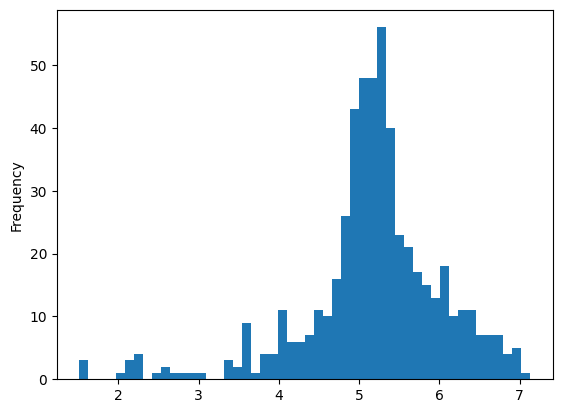

In [22]:
proj['Greenhouse Gases (CO2e)'].replace(0, np.nan).transform(np.log10).plot.hist(bins=50)

#### Date Modified

In [23]:
# to_datetime works on all values present
timestamps = pd.to_datetime(proj['modified_on'])
timestamps.dtypes, timestamps.isna().sum()

(dtype('<M8[ns]'), 0)

#### Jobs
Check array delimiter, naming, and order.

* Array delimiter: can be `,` or `;` or none
* naming: `temporary`, `permanent`, `full-time`, `construction`, `operating` and none given
* order: not consistent. Needs a parser.

In [24]:
# only 74/672 (11%) have jobs numbers
proj['Number of Jobs Promised'].dropna().shape

(120,)

In [25]:
jobs = proj['Number of Jobs Promised'].dropna()

**What special characters are present?**

In [26]:
from functools import reduce
reduce(set.union, [set(item) for item in jobs.str.replace('\d+|\w+|\s+', '', regex=True).to_list()])

{'(', ')', ',', '-', ';', '>'}

In [27]:
# not a delimiter
jobs[jobs.str.contains('>')]

545    1,000-1,500 construction jobs, >100 permanent ...
Name: Number of Jobs Promised, dtype: object

In [28]:
# not an array delimiter. It is a range delimiter
jobs[jobs.str.contains('-')]

39     200 construction jobs; 40 full-time jobs (for ...
135                   1500-2000 temporary; 200 full-time
247                             1500-2000 temporary jobs
260                    3,500 construction; 500 full-time
282          400 full-time jobs; 6,000 construction jobs
293                   1400-3000 temporary; 250 permanent
296                                                35-50
338                       40-260 temporary; 28 permanent
522                                                10-20
535                      350-520 temporary; 12 permanent
545    1,000-1,500 construction jobs, >100 permanent ...
548                                    150-200 permanent
570                        70-110 temporary; 2 permanent
639                   200-300 temporary, 10-20 permanent
660                                   240 full-time jobs
762                           12 full-time, 13 temporary
Name: Number of Jobs Promised, dtype: object

In [29]:
# not a delimiter
jobs[jobs.str.contains('\(|\)')]

39    200 construction jobs; 40 full-time jobs (for ...
Name: Number of Jobs Promised, dtype: object

**What job types are present?**

In [30]:
jobs.str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       39
temporary       37
construction    15
jobs            12
full             6
time             6
County           2
in               2
built            2
if               2
operating        2
peak             1
Calhoun          1
job              1
Unknown          1
including        1
during           1
pipeline         1
Project          1
SMP              1
BWTX             1
entire           1
the              1
for              1
Howard           1
Name: 0, dtype: int64

In [31]:
# repeat but without that long parenthetical
jobs.str.replace('\(.+\)', '', regex=True).str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       39
temporary       37
construction    14
jobs            12
full             6
time             6
built            2
County           2
operating        2
in               2
if               2
Calhoun          1
Unknown          1
job              1
peak             1
during           1
Howard           1
Name: 0, dtype: int64

I think `permanent`, `full-time` and `operating` are equivalent. And `temporary` == `construction`. And `Unkown` is Null.

### Range Validation
Check IDs, Emissions, Cost, Jobs, expected completion year
#### Emissions
Kind of hard to interpret, but no outrageous smoking guns

In [32]:
emission_cols = [
    'Greenhouse Gases (CO2e)',
    'Particulate Matter (PM2.5)',
    'Nitrogen Oxides (NOx)',
    'Volatile Organic Compounds (VOC)',
    'Sulfur Dioxide (SO2)',
    'Carbon Monoxide (CO)',
    'Hazardous Air Pollutants (HAPs)',
]

In [33]:
# sulfur is missing due to type error
proj[emission_cols].describe()

,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs)
count,5.530000e+02,637.000000,633.000000,642.000000,632.000000,635.000000,371.000000
mean,6.305799e+05,32.121092,132.131862,236.227598,32.295761,260.355883,16.574373
std,1.448795e+06,92.655146,431.099359,1635.819112,145.059558,820.372079,85.468400
min,-1.303318e+06,-211.020000,-2191.800000,-77.330000,-1132.996900,-592.500000,-59.780000
25%,7.025300e+04,3.100000,21.320000,13.400000,0.447500,30.310000,1.000000
50%,1.579210e+05,8.080000,46.680000,33.660000,2.750000,75.000000,4.168000
75%,4.143300e+05,20.740000,102.410000,93.585000,17.497500,192.680000,11.935000
max,1.362809e+07,1303.300000,4335.000000,24657.200000,2094.200000,11891.200000,1230.000000


In [34]:
# a single value causes the issue
proj.loc[proj['Sulfur Dioxide (SO2)'].str.contains(',').fillna(False), ['id', 'name', 'Sulfur Dioxide (SO2)']]

AttributeError: Can only use .str accessor with string values!

In [ ]:
sulfur = pd.to_numeric(proj['Sulfur Dioxide (SO2)'].str.split(',').str[0], errors='raise')

In [35]:
sulfur.describe()

NameError: name 'sulfur' is not defined

In [ ]:
emission_cols.remove('Sulfur Dioxide (SO2)')

In [36]:
extremely_large_idx = [proj.loc[:, col].nlargest(5).index for col in emission_cols]# + [sulfur.nlargest(5).index]

In [37]:
extremely_large = pd.Index([])
for index in extremely_large_idx:
    extremely_large = extremely_large.union(index)
extremely_large

Index([ 37,  39,  43,  92,  98, 100, 113, 137, 147, 148, 150, 151, 215, 221,
       275, 303, 329, 386, 404, 422, 560, 611, 714],
      dtype='object')

In [38]:
proj.loc[extremely_large, ['id', 'name', 'Project Description', 'Sulfur Dioxide (SO2)'] + emission_cols].sort_values('Greenhouse Gases (CO2e)')

,id,name,Project Description,Sulfur Dioxide (SO2),Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs)
386,3119,Texas GulfLink Deepwater Port - Initial Constr...,The Texas GulfLink Terminal Project would cons...,20.16,8862.00,3.23,59.82,10025.14,20.16,56.59,NaN
98,2822,Coyote Springs Compressor Station - Initial Co...,Construction of a new compressor station along...,0.06,13402.00,0.56,30.43,2.46,0.06,38.24,182.95
37,2760,Blue Marlin Offshore Port - Initial Construction,Construction of a new offshore deepwater expor...,1.64,16503.00,1.07,26.02,21881.00,1.64,57.88,1230.00
39,2762,Bluewater SPM Deepwater Port - Initial Constru...,Construction of a new deepwater port in the fe...,NaN,185453.00,NaN,NaN,18936.25,NaN,NaN,833.18
422,3157,Wood River CORE Expansion and Hartford Termina...,Modifications to increase processing capacity ...,2094.20,209350.00,161.30,920.40,327.30,2094.20,882.40,NaN
150,2877,Geismar Methanol Plant 3 and G1/G2 Debottlenec...,Construction of a third methanol plant (Geisma...,1.60,457375.00,19.91,32.94,21.30,1.60,154.26,633.89
43,2766,"Borger Refinery, Crude Flexibility and Moderni...",Installation of a new Continuous Catalytic Ref...,647.89,470082.58,890.69,368.35,644.55,647.89,2722.41,NaN
275,3005,Equistar Corpus Christi - Olefins Plant Expansion,An expansion project to increase annual ethyle...,1263.76,2062725.00,92.30,2264.06,452.81,1263.76,1638.85,NaN
151,2878,Geismar Methanol Plants 1 and 2,Construction of a new methanol plant consistin...,10.56,2080568.00,136.63,178.70,68.40,10.56,175.22,258.63
404,3138,Valero Port Arthur Refinery Expansion Project,"Construction of a new delayed coking unit, a n...",790.20,2862639.00,62.61,128.40,535.20,790.20,363.98,NaN


In [39]:
import matplotlib.pyplot as plt

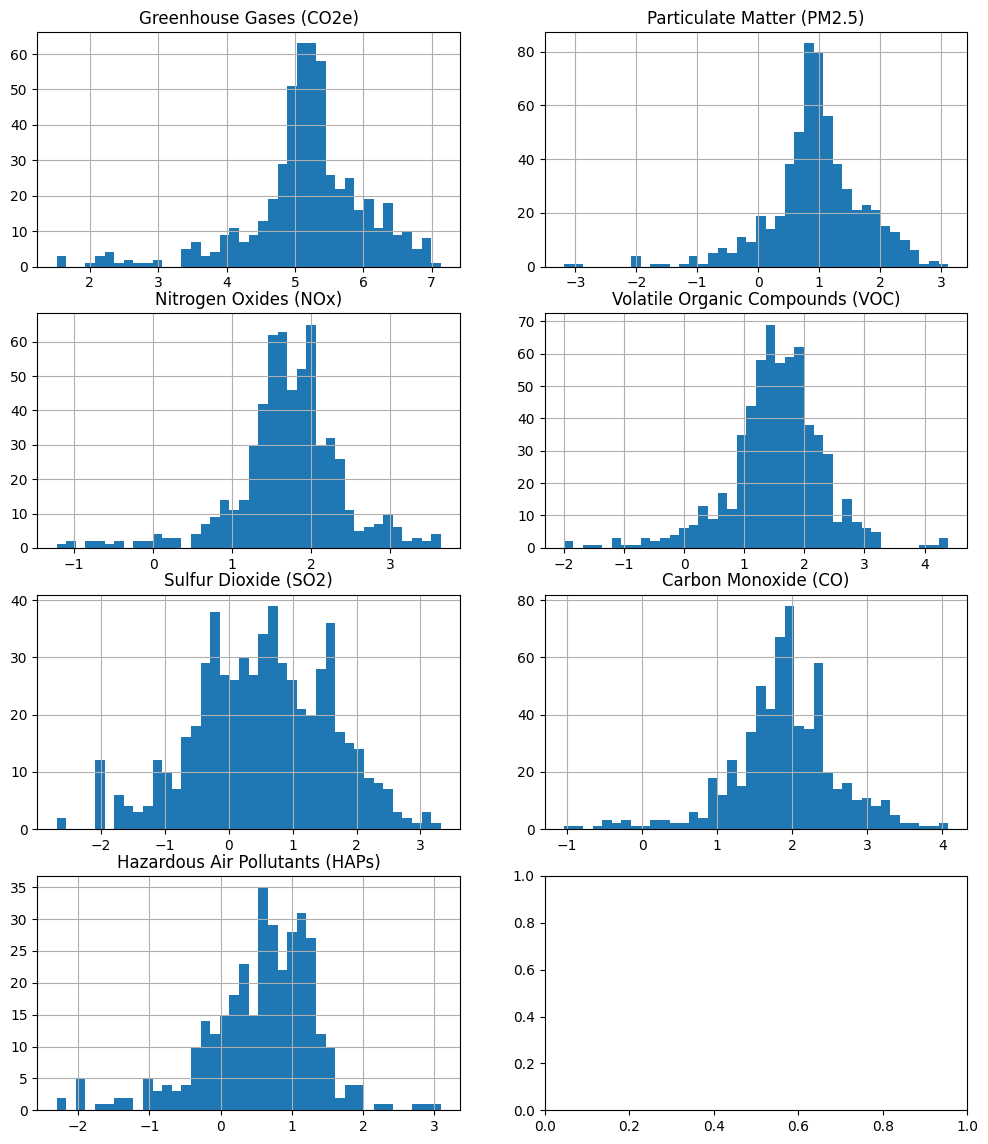

In [46]:
# NOTE: this only includes positive values (most but not all of them)
n = len(emission_cols)#+1
fig, axes = plt.subplots(nrows=round(n/2+0.4), ncols=2, figsize=(12, n*2))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].replace(0,np.nan).transform(np.log10).hist(bins=40, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)
#sulfur.replace(0,np.nan).transform(np.log10).hist(bins=40, ax=axes[n-1])

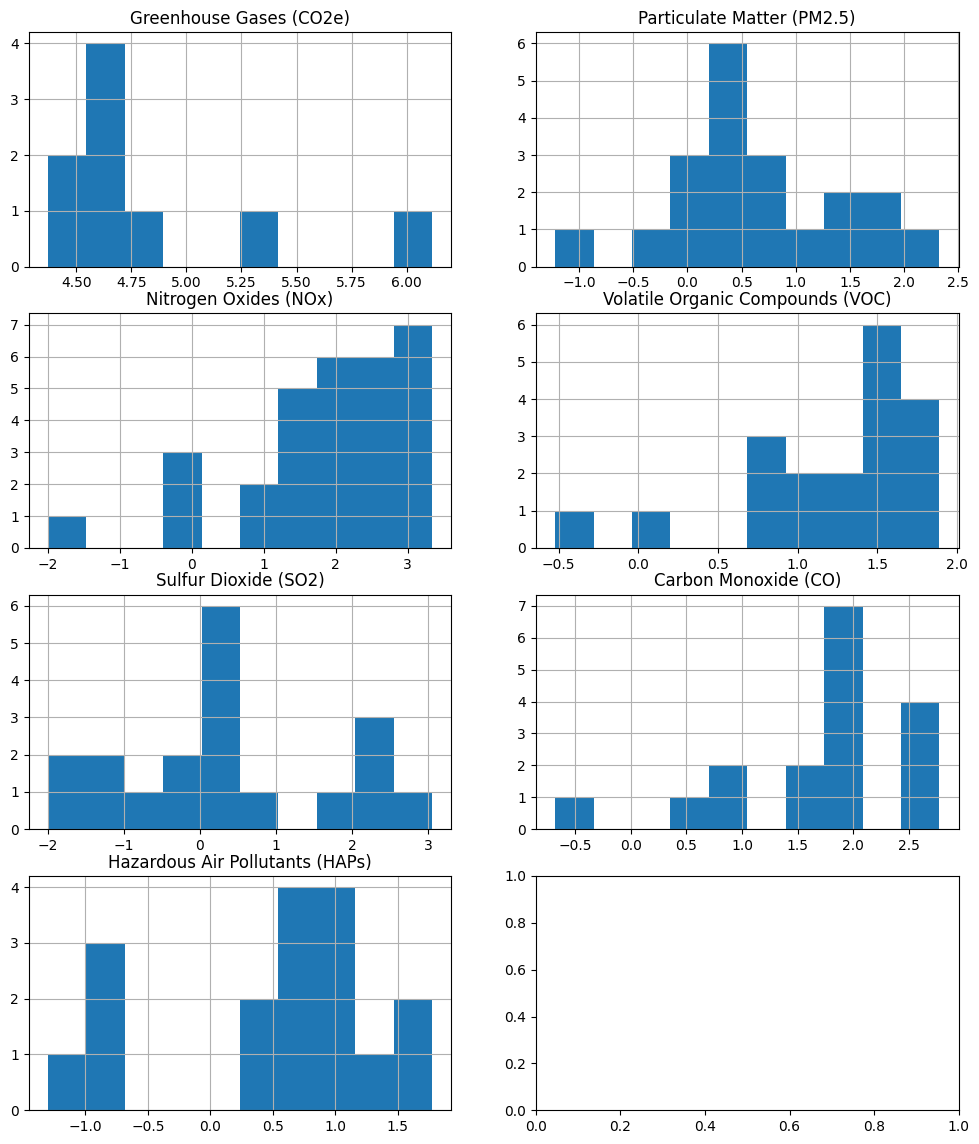

In [47]:
# Negative values only
n = len(emission_cols)#+1
fig, axes = plt.subplots(nrows=round(n/2+0.4), ncols=2, figsize=(12, n*2))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].mul(-1).replace(0,np.nan).transform(np.log10).hist(bins=10, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)
#sulfur.mul(-1).replace(0,np.nan).transform(np.log10).hist(bins=10, ax=axes[n-1])

#### IDs
There are lots of ID columns, but I only care about Facility IDs and Air Construction IDs

In [48]:
# defined way up near the top
id_cols

['Facility (ID)',
 'Air Construction (ID)',
 'Air Operating (ID)',
 'NGA (ID)',
 'Other Permits (ID)']

In [49]:
fac_ids = proj['Facility (ID)'].str.split(',', expand=True)
for col in fac_ids.columns:
    fac_ids.loc[:, col] = pd.to_numeric(fac_ids.loc[:, col], errors='coerce')

fac_ids.head()

,0,1
0,739.0,NaN
1,740.0,NaN
2,741.0,NaN
3,742.0,NaN
4,758.0,NaN


In [50]:
# they all look in the same range
fac_ids.describe()

,0,1
count,766.000000,3.000000
mean,2100.548303,3647.333333
std,1695.602714,79.462780
min,739.000000,3598.000000
25%,883.250000,3601.500000
50%,1033.500000,3605.000000
75%,3822.750000,3672.000000
max,5500.000000,3739.000000


In [51]:
air_const_ids = proj['Air Construction (ID)'].str.split(',', expand=True)
for col in air_const_ids.columns:
    air_const_ids.loc[:, col] = pd.to_numeric(air_const_ids.loc[:, col], errors='coerce')

air_const_ids.head()

,0,1,2,3,4,5,6
0,1573.0,1574.0,4137.0,4826.0,NaN,NaN,NaN
1,2079.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2361.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2181.0,2182.0,4266.0,NaN,NaN,NaN,NaN
4,1578.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# they all look in the same range
air_const_ids.describe()

,0,1,2,3,4,5,6
count,583.000000,179.000000,67.000000,26.000000,10.000000,4.000000,1.0
mean,2705.277873,2923.050279,3029.641791,2641.846154,2490.600000,2426.000000,1675.0
std,1161.032962,1266.747114,1318.612985,1250.288981,1055.478007,1153.413774,NaN
min,1573.000000,1574.000000,1620.000000,1621.000000,1622.000000,1623.000000,1675.0
25%,1901.500000,1908.500000,1836.000000,1676.750000,1662.500000,1661.250000,1675.0
50%,2194.000000,2237.000000,2341.000000,2159.000000,2045.000000,1995.500000,1675.0
75%,3638.000000,4238.000000,4239.000000,3313.500000,3282.000000,2760.250000,1675.0
max,5503.000000,5450.000000,5501.000000,5001.000000,4243.000000,4090.000000,1675.0


#### Project Cost
Check uniformity at the same time: should be in millions of dollars. Check vs thousands or single dollars.

<AxesSubplot:>

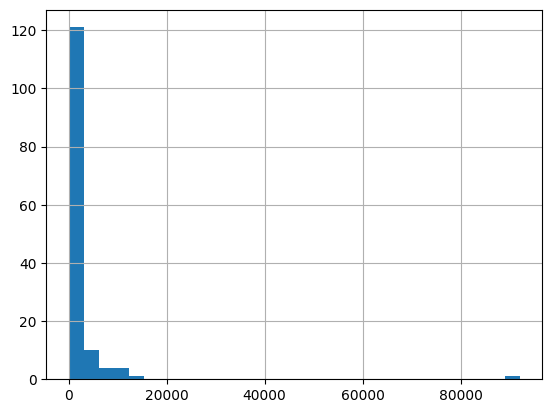

In [53]:
# wrong dtype
proj['Project Cost (million $)'].hist(bins=30)

By manual inspection (there are not that many values present), I see that there are a handful of values of the form "XX, XX". The first number is repeated in an array. So I want to use the same method that fixed the identical issue in the `State` column. But first I need to check that there are no commas present as thousands separators or for other reasons. Check that a split on commas produces two identical values:

In [54]:
proj['Project Cost (million $)'].str.split(',', expand=True).dropna()

AttributeError: Can only use .str accessor with string values!

In [ ]:
# definitely no single dollar amounts.
# As for thousands, check that the 8-14 billion dollar projects are plausible
cost = pd.to_numeric(proj['Project Cost (million $)'].str.split(',').str[0], errors='raise')
cost.hist(bins=20)

In [ ]:
# log transform
cost.transform(np.log10).hist(bins=20)

In [ ]:
# Yes, costs are in millions. If they were in thousands, it would mean these megafacilities were being built with 6-14.5 million dollars. I'd buy one at that price!
pd.set_option('display.max_colwidth', 0)
proj.loc[cost.nlargest(8).index, ['name', 'Project Cost (million $)', 'Project Description']]

#### Jobs
Skipping for now becuase I need to make a parser first.

### Uniqueness Validation
Check the `id` field

In [55]:
proj['id'].duplicated().sum()

0

### Set Membership Validation
* classification
* industry sector
* project type
* operating status

#### Classification
Doesn't look like any erroneous categories to me.

In [56]:
proj['Classification'].value_counts()

Expansion     386
New           359
Conversion     12
Restart         7
Name: Classification, dtype: int64

#### Industry Sector
A single one:many array value. Simplify by picking one

In [57]:
proj['Industry Sector'].value_counts()

Natural Gas                                                  319
Petrochemicals and Plastics                                  216
Oil                                                           93
Liquefied Natural Gas                                         45
Other                                                         40
Synthetic Fertilizers                                         39
Other, Synthetic Fertilizers, Petrochemicals and Plastics      2
Other, Petrochemicals and Plastics                             2
Oil, Other                                                     2
Liquefied Natural Gas, Other                                   1
Synthetic Fertilizers, Other, Petrochemicals and Plastics      1
Petrochemicals and Plastics, Oil, Other                        1
Oil, Petrochemicals and Plastics                               1
Synthetic Fertilizers, Petrochemicals and Plastics             1
Petrochemicals and Plastics, Other                             1
Other, Oil               

#### Project Type
This column has a fair number of multivalued array entries. But the categories themselves look consistent -- no mis-spellings, etc.

In [58]:
proj['Project Type'].value_counts()

Compressor Station                                                                   251
Gas Processing Plant                                                                  62
Refinery                                                                              54
Liquefied Natural Gas Terminal or Liquefaction Plant                                  43
Natural Gas Liquids Fractionator                                                      35
Plastic Resin Manufacturing                                                           31
Ethylene Cracker                                                                      28
Crude Oil Terminal                                                                    27
Ammonia/Urea Plants                                                                   26
Other Chemicals                                                                       23
Methanol Plant                                                                        21
Renewable Diesel or G

In [59]:
# split and combine value counts
proj['Project Type'].str.split(',', expand=True).stack().str.strip().value_counts()

Compressor Station                                      252
Gas Processing Plant                                     81
Refinery                                                 56
Natural Gas Liquids Fractionator                         56
Liquefied Natural Gas Terminal or Liquefaction Plant     44
Plastic Resin Manufacturing                              42
Ethylene Cracker                                         39
Crude Oil Terminal                                       28
Ammonia/Urea Plants                                      28
Other Chemicals                                          25
Methanol Plant                                           21
Renewable Diesel or Gasoline Refinery                    19
Propylene Dehydrogenation (PDH) Plant                    13
Hydrogen Plant                                           12
Blue Ammonia                                             12
Natural Gas Liquids Storage Facility                     12
Blue Hydrogen                           

#### Operating Status
Just need to replace "Unknown" with Null

In [60]:
proj['Operating Status'].value_counts()

Operating              371
Pre-construction       186
Announced               94
Under construction      46
Canceled                33
Partially operating     17
On hold                 16
Unknown                  2
Commissioning            1
Name: Operating Status, dtype: int64

### Type Validation
Already did this while doing range validation, but `Sulfur Dioxide (SO2)`and `Project Cost` require parsing duplicative csv array values in what should be a numeric column. Also, `Number of Jobs Promised` needs parsing into two columns: permanent and temporary jobs.

#### Completion Year
I started converting this to numeric, but would have to model multi-valued items. I think the benefit (sorting, quantitative analysis) is small relative to 1) the cost it will take to communicate the modeling and 2) actually doing the modelling. I think we have other fields we would filter on first.

<AxesSubplot:>

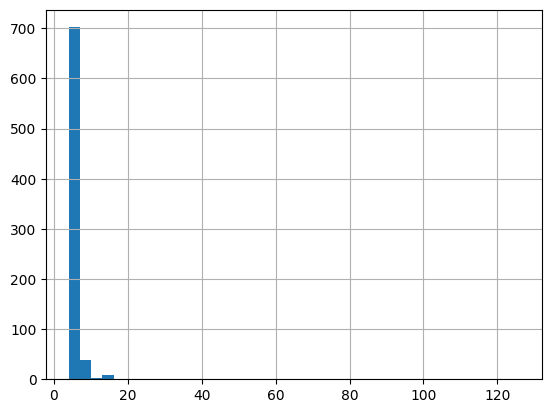

In [61]:
proj['Actual or Expected Completion Year'].str.len().hist(bins=40)

In [62]:
proj['Actual or Expected Completion Year'].str.len().nlargest(8)

560    126.0
329     79.0
620     19.0
202     14.0
229     14.0
265     14.0
273     14.0
333     14.0
Name: Actual or Expected Completion Year, dtype: float64

In [63]:
proj.loc[proj['Actual or Expected Completion Year'].str.len().nlargest(8).index, 'Actual or Expected Completion Year']

560    Train 5 began operating in 2019. Commissioning...
329    Trains 1 and 2 began operating in 2016. Trains...
620                                  2015/2018/2020/2022
202                                       2018/2020/2021
229                                       2013/2015/2020
265                                       2015/2017/2020
273                                       2014/2016/2018
333                                       2015/2016/2019
Name: Actual or Expected Completion Year, dtype: object

### Cross-Field Validation
None really needed. I could check that the date columns are in a logical order (modified > created, for example) but I'm not planning to really use those columns. So I skipped it.